In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import mixture
from scipy.stats import norm, multivariate_normal
from sklearn.metrics import r2_score, mean_squared_error

import pylab as plt
import seaborn as sbn
from matplotlib.mlab import bivariate_normal
from mpl_toolkits.mplot3d import Axes3D

# Normal Distribution

사람의 키, 측정치의 오류률, 혈압, 시험성적등등 많은 데이터의 유형이 gaussian distribution(normal distribution)을 따릅니다. <br>
평균값과 분산값만 알고 있다면 central theorem을 통해 분포도를 알 수 있습니다.<br>
> 데이터가 정규분포를 따를때.. <br>
> 68%는 1 std안에 존재하고, 95%는 2 std안에 존재하며, 99.7%는 3 std안에 존재합니다.

Gaussian distribution의 공식은 다음과 같으며, probability density function으로도 불립니다.<br>
PDF는 어떤 구간[a, b] 안에 확률 변수 X가 포함될 확률을 나타냅니다.

$$ y = \frac{1}{\sqrt{2\pi \sigma^2}} exp \left(-\frac{(x-\mu)^2}{2 \sigma^2} \right) $$


앞의 계수(coefficient) $ \frac{1}{\sqrt{2\pi \sigma^2}} $는 x에 의존하지 않는 상수로 볼 수 있습니다.<br>
따라서 일종의 normalization factor로 볼 수 있습니다.

$ -\frac{(x-\mu)^2}{2 \sigma^2} $ 이 부분이 quadratic function (2차함수) of the variable x 입니다.<br>
2차함수의 계수(the coefficient of the quadratic term)는 음수이므로 포물선(parabola)는 downwards입니다.

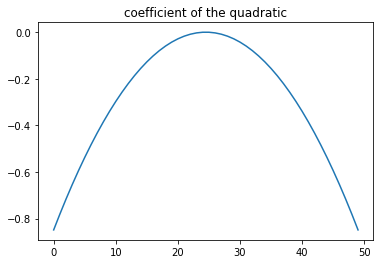

In [2]:
def downwards_parabola(x):
    mean = np.mean(x)
    std = np.std(x)
    r = -(x - mean)**2/(2*std)
    return r

x = np.linspace(-1., 1., 50)
plt.plot(downwards_parabola(x))
plt.title('coefficient of the quadratic')

## Scipy Normal Distribution

**scipy.stats.norm.pdf(x, loc=0, scale=1)** 을 사용해서 Standardard Normal Distribution을 사용할수 있습니다.<br>
만약 위의 일반정규분포공식을 사용하고자 한다면 **scipy.stats.norm.pdf(x, loc=np.mean(x), scale=np.sqrt(np.std(x)))** 이렇게 사용해야 합니다.

Mean: 10.0 STD : 2.14932341883
MSE General  Normal Distribution: 1.20888447813e-30
MSE Standard Normal Distribution: 0.0


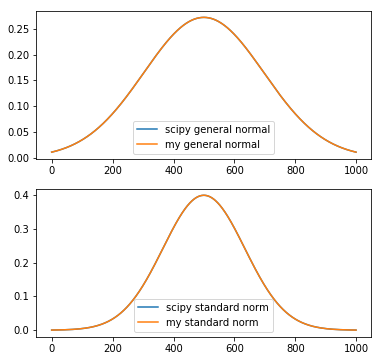

In [3]:
def general_norm_pdf(x):
    std = np.std(x)
    mean = np.mean(x)
    r = np.exp(-(x-mean)**2/(2*std))/np.sqrt(2 * np.pi * std)
    return r

def standard_norm_pdf(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

def example_normal_distributions(mean=10):
    x = np.linspace(norm.ppf(0.0001), norm.ppf(0.9999), 1000) + mean
    SCALE = np.std(x)
    
    general_norm_data1 = norm.pdf(x, loc=mean, scale=np.sqrt(np.std(x)))
    general_norm_data2 = general_norm_pdf(x)

    std_norm_data1 = norm.pdf(x, loc=mean)
    std_norm_data2 = standard_norm_pdf((x-mean))

    fig, plots = plt.subplots(2)
    fig.set_figheight(6)
    plots[0].plot(general_norm_data1, label='scipy general normal')
    plots[0].plot(general_norm_data2, label='my general normal')
    plots[1].plot(std_norm_data1, label='scipy standard norm')
    plots[1].plot(std_norm_data2, label='my standard norm')
    plots[0].legend()
    plots[1].legend()
    
    print('Mean:', np.mean(x), 'STD :', np.std(x))
    print('MSE General  Normal Distribution:', mean_squared_error(general_norm_data1, general_norm_data2))
    print('MSE Standard Normal Distribution:', mean_squared_error(std_norm_data1, std_norm_data2))
example_normal_distributions()

## Sampling Distribution of the Mean

어떤 분포이든지간에 표본의 평균(sample mean)은 normal distribution을 따릅니다.<br>
예를 들어서 2000명의 학생들이 종이 쪽이에 0에서 100사이의 숫자를 적은뒤 상자안에 넣습니다.<br>
수학선생님이 랜덤으로 30개의 종이쪽지를 꺼내서 평균을 냅니다. 만약 선생님이 이 작업을 여러번 할 경우<br>
표본의 평균은 확률분포는 정규분포를 갖게 됩니다.<br>
아래는 코드로 설명한 것입니다.

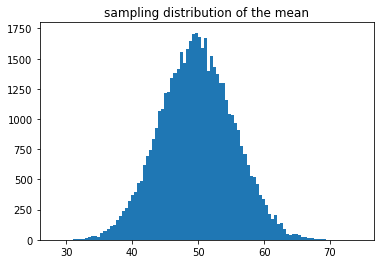

In [4]:
def test_sample_mean_is_normal_distribution(n=1000):
    X = np.random.randint(0, 100, size=2000)
    samples = np.zeros(n, dtype='float32')
    for i in range(n):
        idx = np.random.randint(0, 100, size=30)
        samples[i] = X[idx].mean()
    return samples
    
sample_means = test_sample_mean_is_normal_distribution(n=50000)
plt.hist(sample_means, bins=100)
plt.title('sampling distribution of the mean')
print()

# Multivariate Normal Distribution

한국어로 다변수 또는 다변량 정규분포라고 하며, 다차원의 공간에 확장한 분포입니다.<br>
Probability density function은 다음과 같이 정의 됩니다.


$$ p(x\ |\ \mu, \Sigma) = \frac{1}{\left( 2\pi \right)^{k} \det(\Sigma)^{1/2} } 
exp \left(-\frac{1}{2} (\mathbf{x} - \mu)^T \Sigma^{-1} (\mathbf{x} - \mu) \right) $$

* $ k $ : Component distribution의 갯수
* $ | \Sigma | $ : determinant of $ \Sigma $ 를 가르킵니다. 즉.. $ \det(\Sigma) $ 로 표현될수 있습니다.
* $ \mu \in \mathbb{R}^n $ 이므로 평균값은 1차원의 vector라고 생각하면 됩니다.
* $ \Sigma \in \mathbb{R}^{n*n}  $ 이므로 covariance matrix는 (n, n) shape의 matrix라고 생각하면 됩니다.<br> 
   > <span style="color:#777777">Numpy의 multivariate_normal 사용시 1차원의 vector로 사용도 가능하고, 상수도 됩니다.</span>



In [284]:
from sklearn.mixture import GaussianMixture

x = np.array([[1,2,3], [0,1,0], [5, 2, 4]])
print(x.shape)
gmm = GaussianMixture(1, covariance_type='full')
gmm.fit(x)
print(gmm.means_)
print(gmm.covariances_)

(3, 3)
[[ 2.          1.66666667  2.33333333]]
[[[ 4.66666767  0.66666667  3.        ]
  [ 0.66666667  0.22222322  0.77777778]
  [ 3.          0.77777778  2.88888989]]]


data: (5000, 2)


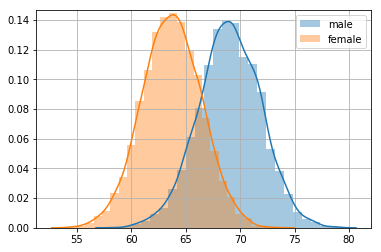

In [369]:
data = pd.read_csv('gender-height-weight.csv', usecols=(0, 1, 2))
# data = pd.get_dummies(data, columns=['Gender'], prefix='', prefix_sep='')

data = np.dstack([data[data['Gender'] == 'Male']['Height'], 
                  data[data['Gender'] == 'Female']['Height']])[0]

print('data:', data.shape)
sbn.distplot(data[:, 0], bins=25, label='male')
sbn.distplot(data[:, 1], bins=25, label='female')
plt.legend()
plt.grid()

In [365]:
np.random.rand(10, 2) * np.random.rand(2)

array([[ 0.05154426,  0.05030454],
       [ 0.24547974,  0.0690999 ],
       [ 0.36792667,  0.17483739],
       [ 0.00068088,  0.17898482],
       [ 0.32902269,  0.05129891],
       [ 0.23274802,  0.06901088],
       [ 0.41162693,  0.1214983 ],
       [ 0.16144508,  0.13697801],
       [ 0.15381734,  0.14909621],
       [ 0.30516301,  0.11920651]])

(5000, 2) (2,) (5000, 5000) -0.0 2
norm: 39.47841760435743


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in double_scalars


(2, 2) [[ nan  inf]
 [ inf  nan]]


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in multiply


ValueError: cannot convert float NaN to integer

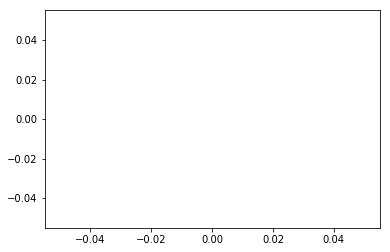

In [397]:
def my_multivariate_gaussian_pdf(x):
    k = x.shape[1]
    mean = x.mean(axis=0)
    cov = np.cov(x, rowvar=True)
    det = np.linalg.det(cov)
    
    print(x.shape, mean.shape, cov.shape, det, k)
    
    norm = 1/((2*np.pi)**(k) * det**(0.5))
    print('norm:', (2*np.pi)**(k))
    quad = np.exp(-1/2 * (x - mean).T @ np.linalg.inv(cov) @ (x-mean))
    return norm * quad
    
x = np.array([[1,2,3], [0,1,0]]).T

r = my_multivariate_gaussian_pdf(data)

print(r.shape, r)
sbn.distplot(r[0], label='male')
# sbn.distplot(r[1], bins=25, label='female')

## Multivariate Gaussian Visualizations

아래의 예제는 2개의 gaussian variables $ X_1 $ 그리고 $ X_2 $를 사용하는 multivariate gaussian density입니다.

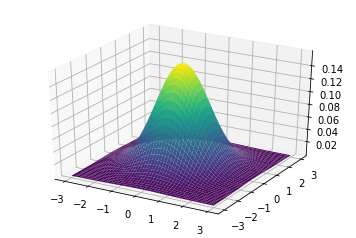

In [401]:
def example_multivariate_normal_distribution():
    x = np.linspace(-3, 3, 1000)
    y = np.linspace(-3, 3, 1000)
    x, y = np.meshgrid(x, y)
    z = bivariate_normal(x, y)
  
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis')
    
example_multivariate_normal_distribution()

아래는 contour로 multivariate gaussian distribution을 타나냈습니다.<br>
예제의 Covariance matrix값이 [[1, 0], [0, 1]] 이므로, Identity matrix입니다.

중앙 밝은색일수록 확률이 더 높다는 뜻입니다.<br>
Convariance matrix값이 커질수록 범위가 더 커집니다.

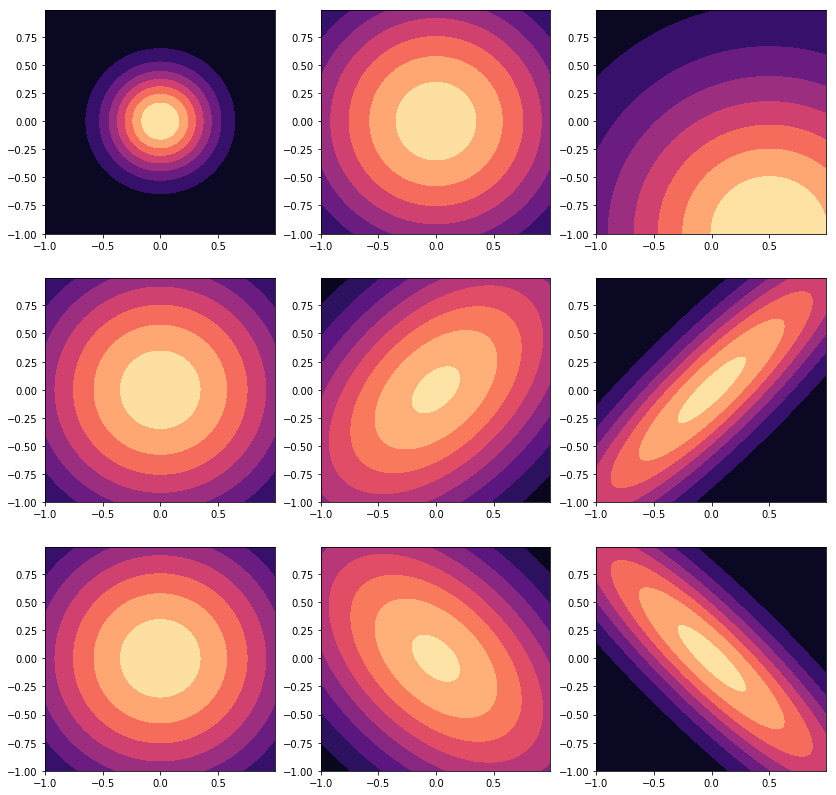

In [130]:
def example_multivariate_normal_distribution2():
    x, y = np.mgrid[-1:1:0.01, -1:1:.01]  
    pos = np.dstack((x, y))
    
    rv1 = multivariate_normal(mean=[0, 0], cov=[[0.1, 0],[0, 0.1]])
    rv2 = multivariate_normal(mean=[0, 0], cov=[[1, 0],[0, 1]])
    rv3 = multivariate_normal(mean=[0.5, -1], cov=[[1, 0],[0, 1]])
    
    rv4 = multivariate_normal(mean=[0, 0], cov=[[1, 0],[0, 1]])
    rv5 = multivariate_normal(mean=[0, 0], cov=[[1, 0.5],[0.5, 1]])
    rv6 = multivariate_normal(mean=[0, 0], cov=[[1, 0.9],[0.9, 1]])
    
    rv7 = multivariate_normal(mean=[0, 0], cov=[[1, 0],[0, 1]])
    rv8 = multivariate_normal(mean=[0, 0], cov=[[1, -0.5],[-0.5, 1]])
    rv9 = multivariate_normal(mean=[0, 0], cov=[[1, -0.9],[-0.9, 1]])
    
    fig, subplots = plt.subplots(3, 3)
    fig.set_figwidth(14)
    fig.set_figheight(14)
    subplots = subplots.reshape(-1)
    
    subplots[0].contourf(x, y, rv1.pdf(pos), cmap='magma')
    subplots[1].contourf(x, y, rv2.pdf(pos), cmap='magma')
    subplots[2].contourf(x, y, rv3.pdf(pos), cmap='magma')
    
    subplots[3].contourf(x, y, rv4.pdf(pos), cmap='magma')
    subplots[4].contourf(x, y, rv5.pdf(pos), cmap='magma')
    subplots[5].contourf(x, y, rv6.pdf(pos), cmap='magma')
    
    subplots[6].contourf(x, y, rv7.pdf(pos), cmap='magma')
    subplots[7].contourf(x, y, rv8.pdf(pos), cmap='magma')
    subplots[8].contourf(x, y, rv9.pdf(pos), cmap='magma')
    
    
example_multivariate_normal_distribution2()

## Scipy Multivariate Normal Distribution

Mean은 N-dimensional space의 좌표이며 표본데이터가 가장 많이 나타낼 위치입니다. <br>
따라서 일반적인 univariate normal distribution의 peak 부분의 위치와 동일하다고 볼수 있습니다. 

Covariance는 2개의 분포가 서로 유사하게 움직이는지 판단하는데 사용됩니다.<br>
예를 들어 positive covariance는 서로 동일하게 움직인다는 뜻이며 (증가하거나 감소하거나) <br>
Negative covariance의 경우는 서로 반대방향으로 움직이고 있다는 뜻입니다. 

Scipy사용시 full covariance matrix를 사용하지 않고 approximation을 사용합니다.

* Spherical covariance
* Diagonal covariance

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  after removing the cwd from sys.path.


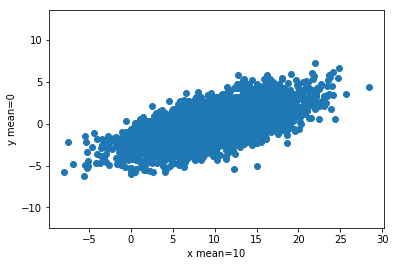

In [368]:
def example_scipy_multivariate_norm():
    mean = [10, 0]
    cov = [[25, 7], [0, -2]]
    multi_norms = np.random.multivariate_normal(mean, cov, 5000)
    x = multi_norms[:, 0]
    y = multi_norms[:, 1]
    plt.scatter(x, y)
    plt.xlabel('x mean=10')
    plt.ylabel('y mean=0')
    plt.axis('equal')

example_scipy_multivariate_norm()

# Guassian Mixture Model

먼저 Mixture Model에 대해서 이해할 필요가 있습니다. <br>
Mixture Model이란 여러개의 component distributions을 갖고있는 일종의 probability density model입니다.<br>
여기서 component distributions이 gaussians이기 때문에 guassian mixture model이라는 이름이 사용되는 것입니다.

분포도가 아래와 같이 2개의 multi modal distributions으로 이루어져있다면 어떻게 해야 할까요?<br>
결론적으로.. 추가적인 gaussian distribution을 추가해주면 됩니다! <br>
Gaussian Mixture Model은 이런 개념에서 출발한다고 보면 됩니다.

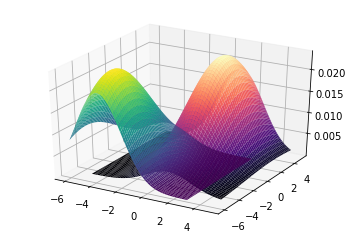

In [56]:
sigmax = np.sqrt(3)
sigmay = np.sqrt(15)
x1 = np.linspace(-5, 5, 100)
y1 = np.linspace(-5, 5, 100)
x1, y1 = np.meshgrid(x1, y1)

x2 = np.linspace(-6, 3, 100)
y2 = np.linspace(-6, 3, 100)
x2, y2 = np.meshgrid(x2, y2)
z1 = bivariate_normal(x1, y1, sigmax=sigmax, sigmay=sigmay, mux=1, muy=2.2)
z2 = bivariate_normal(x2, y2+4, sigmax=sigmax, sigmay=sigmay, mux=-3.7, muy=0.1)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x1, y1, z1, cmap='magma', linewidth=0)
ax.plot_surface(x2, y2, z2, cmap='viridis', linewidth=0)

# Model

Gaussian mixture model (GMM)은 univariate normal distribution과 multivariate normal distribution으로 나뉩니다.<br>
Univariate normal distribution의 경우는 일반적인 normal distribution의 probability density function을 가르킵니다.

## One Dimensional Model (Univariate)

위에서 이야기 했듯이, gaussian을 추가하며, 일반적인 normal distribution의 probability density function과 공식이 동일합니다.<br>
weights $ w $ 값의 합은 1이 됩니다.

$$ \begin{align}
p(x) &= \sum^K_{i=1} w_i \mathcal{N}\left(x\ |\ \mu_i, \sigma_i\right)  \\
\mathcal{N}\left( x\ |\ \mu_i, \sigma_i \right) &= \frac{1}{\sqrt{2\pi \sigma^2_i}} 
exp\left(- \frac{(x - \mu_i)^2}{2 \sigma^2_i} \right) \\
\sum^K_{i=1} w_i &= 1
\end{align} $$

* $ K $ : K개의 components를 뜻하며, component는 gaussian distribution을 뜻함
* $ w $ : component weights
* $ \mu $ : 평균값
* $ \sigma $ : variance


## Multi-Dimensional Model (Multivariate)

[Edit this wiki Multivariate Normal Distribution](https://brilliant.org/wiki/multivariate-normal-distribution/) 을 참고합니다.


$$ \begin{align} 
p(\vec{x}) &= \sum^K_{i=1} w_i \mathcal{N} \left( \vec{x}\ |\ \vec{\mu}_i, \Sigma_i \right) \\
\mathcal{N}\left( \vec{x} \ |\ \vec{\mu}_i, \Sigma_i \right) &= 
\frac{1}{\sqrt{(2\pi)^K | \Sigma_i |}} exp \left( -\frac{1}{2} 
\left( \vec{x} - \vec{\mu}_i \right)^T \Sigma_i^{-1} \left( \vec{x} - \vec{\mu}_i \right) \right) \\
\sum^K_{i=1} w_i &= 1
\end{align} $$

* $ k $ : Component distribution의 갯수
* $ w $ : prior praobability
* $ \Sigma $ : covariance matrix of the Gaussian


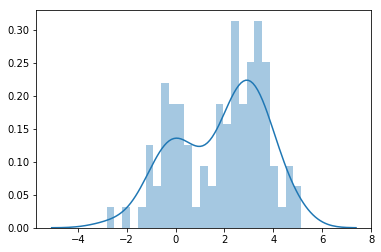

In [127]:
x = np.array(pd.read_csv('bimodal_example.csv'))
sbn.distplot(x, bins=25)

[[ 3.03823226]
 [-0.11889241]]
[[ 0.74927808]
 [ 0.8972336 ]]


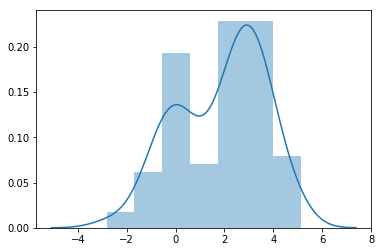

In [158]:
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(x)
print(gmm.means_)
print(gmm.covariances_[:, 0])
colors = ['r' if i==0 else 'g' for i in gmm.predict(x)]

sbn.distplot(x)
# ax = plt.gca()
# ax.scatter()

# Expectation Maximization for Gaussian Mixture Models

GMM의 Expectation maximizationdms 2개의 단계로 이루어 집니다.<br>

1. **Expectation (E)**: 주어진 모델의 parameters를 갖고서 probability distribution을 구합니다. 
2. **Maximization (M)**: 주어진 데이터를 갖고서, 모델을 업데이트하기 위해 parameters을 측정합니다.

In [59]:
from sklearn.datasets import load_iris
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import train_test_split

# IRIS Classifier using GMM

In [97]:
iris = load_iris()
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=0)
train_idx, test_idx = next(iter(skf.split(iris.data, iris.target)))

train_x = iris.data[train_idx]
train_y = iris.target[train_idx]
test_x = iris.data[test_idx]
test_y = iris.target[test_idx]

(array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
         23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
         36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
         72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
        147, 148, 149]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109]))

In [38]:
n_classes = len(np.unique(iris.target))
gmm = GaussianMixture(n_components=n_classes, covariance_type='full', init_params='wc')

# Classifier based on Gaussian Mixture Models


In [134]:
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold

## Data

In [168]:
iris = load_iris()
skf = StratifiedKFold(n_splits=5, random_state=0)
for train_idx, test_idx in skf.split(iris.data, iris.target):
    print(iris.data[train_idx].mean(), iris.target[test_idx])

3.45708333333 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
3.46541666667 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
3.449375 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
3.46229166667 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
3.48416666667 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]


# References

* [Brilliant Gaussian Mixture Model](https://brilliant.org/wiki/gaussian-mixture-model/)
* [Quick introduction to gaussian mixture models with python](http://www.nehalemlabs.net/prototype/blog/2014/04/03/quick-introduction-to-gaussian-mixture-models-with-python/)
* [Siraj Raval](https://github.com/llSourcell/Gaussian_Mixture_Models/blob/master/intro_to_gmm_%26_em.ipynb)
* [The Multivariate Gaussian Distribution](http://cs229.stanford.edu/section/gaussians.pdf)
* [1D Gaussian Mixture Example](http://www.astroml.org/book_figures/chapter4/fig_GMM_1D.html)